# Machine Learning Application 1: Rock Paper Scissors classification
2021 08 16 Maarten Pennings Added TensorFlow Lite  
2021 08 15 Maarten Pennings Created  

The goal of this notebook is to develop a CNN that is able to classify images as rock, paper, or scissors. The images shall be shot and clssified by and ESP32-CAM, see other github [project](https://github.com/maarten-pennings/esp32cam/tree/main/rock-paper-scissors) for the embedded aspects.

# The project directory
Check my [first ML project](https://github.com/maarten-pennings/MachineLearning/blob/main/creditcard/ML1CreditCard.ipynb) for details on the setup. Basically you need

- Python on your system
- Start with an empty project directory; then copy `requirements.txt`, `setup.bat`, `run.bat`, and `rock-paper-scissors.ipynb` into it.
- Run `setup.bat` to create a virtual Python environment (in subdirectory `env` in the project directory).
- Note that several packages will be installed (including Jupyter), as listed in `requirements.txt`.
- Run `run.bat` to run the Jupyter server and client (web page in you browser).
- Open this file (`rock-paper-scissors.ipynb`).

To get reproducible results, we seed the random generators.

In [1]:
import random
import numpy as np
import tensorflow as tf

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Importing and checking the data
On my PC the image data is in a different project, still a github [repo](https://github.com/maarten-pennings/esp32cam/tree/main/rock-paper-scissors). I use a relative path to get there from this project. The data directory has a subdirectory per class. Note that we have one class extra: `none` for images without a hand.

In [2]:
import os
datadir = "../../esp32cam/rock-paper-scissors/data"
categories = os.listdir(datadir)
print( categories )

['none', 'paper', 'rock', 'scissors']


We import all images (`x`) and their categories (`y`). The categories are numbers (0, 1, 2, 3), and index into the labels `categories[]`. After we convert the read images into a numpy array, we see that we have 200 images of 46×28 pixels.

In [3]:
import imageio
x = []
y = []
for ix,category in enumerate(categories) :
    categorydir = os.path.join(datadir,category)
    for filename in os.listdir(categorydir) :
        path = os.path.join(categorydir,filename)
        image = imageio.imread( path )
        x.append(image)
        y.append(ix)
x = np.array(x)
x.shape

(400, 28, 46)

Let's plot one image at full size; we need to pass `imshow` how to map array values to a color: `cmap='gray'`.

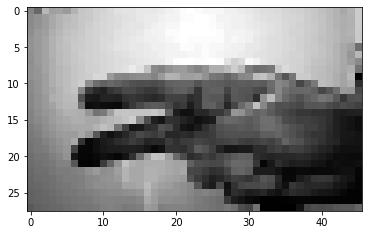

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x[333],cmap='gray');

We also plot a random set of 5×5 images.

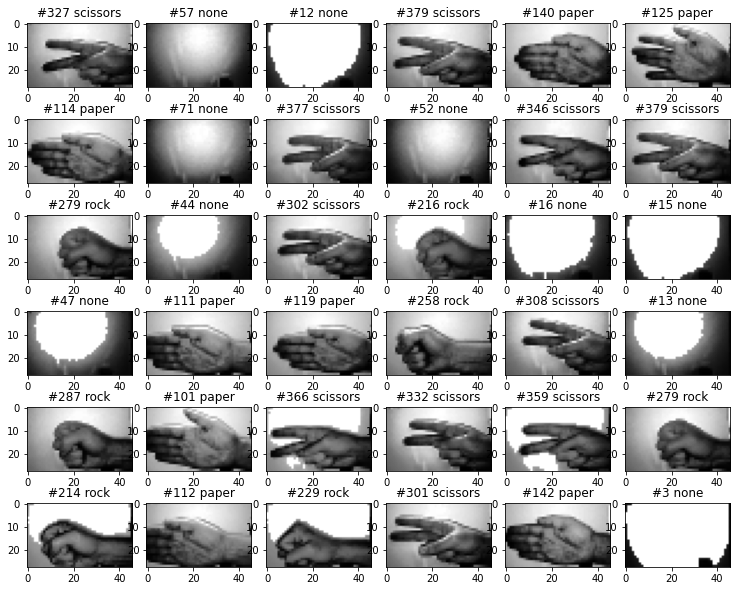

In [5]:
n = 6
fig = plt.figure(n*n,figsize=(15,10))
fig.subplots_adjust(wspace=-0.5,hspace=0.5)
for yy in range(n):
    for xx in range(n):
        ix = random.randrange(0, len(x))
        ax = fig.add_subplot(n,n,yy*n+xx+1)
        ax.title.set_text(f"#{ix} {categories[y[ix]]}")
        plt.imshow(x[ix],cmap='gray')

There is relatively a lot of white pixels (bin 255), but for the rest the histogram is flat.

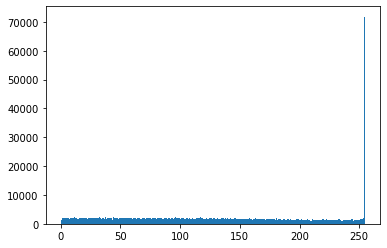

In [6]:
plt.hist(x.reshape(-1),bins=256);

# Intermezzo: histogram normalization

In developing this project, I noticed there is quite some variation in brightness of the shots. 
I was wondering if I needed a preprocessing step to normalize that.
I thought yes, and I picked histogram equalization. 

I added that to the ESP code and captured a new set of images.
The result is what we saw at the end of the previous chapter.

This chapter was used to pilot the code, that was added to the ESP.

In [7]:
def histeq(img) :
    bins = np.zeros((256,),dtype=np.uint)
    for val in img.reshape(-1): 
        bins[val]+=1
    #for i,v in enumerate(bins):
    #    if v>0 : print(i,v)
    cdf=np.zeros((256,),dtype=np.uint)
    prev = 0
    for i,v in enumerate(bins): 
        prev = prev + v
        cdf[i] = prev
    #for i,v in enumerate(bins):
    #    if v>0 : print(i,cdf[i])        
    for v in bins:
        if v>0 : 
            cdfmin = v
            break
    # print(cdfmin)
    def h(v) : 
        return np.round(255*(cdf[v]-cdfmin)/(cdf[255]-cdfmin))
    return h(img)

The above algorithm comes from the [wiki page](https://en.wikipedia.org/wiki/Histogram_equalization). We apply it to the example from the same wiki page; the results match.

In [8]:
ex = np.array([
  [ 52,  55,  61,  59,  79,  61,  76,  61],
  [ 62,  59,  55, 104,  94,  85,  59,  71],
  [ 63,  65,  66, 113, 144, 104,  63,  72],
  [ 64,  70,  70, 126, 154, 109,  71,  69],
  [ 67,  73,  68, 106, 122,  88,  68,  68],
  [ 68,  79,  60,  70,  77,  66,  58,  75],
  [ 69,  85,  64,  58,  55,  61,  65,  83],
  [ 70,  87,  69,  68,  65,  73,  78,  90],    
],dtype=np.uint8)
histeq(ex)

array([[  0.,  12.,  53.,  32., 190.,  53., 174.,  53.],
       [ 57.,  32.,  12., 227., 219., 202.,  32., 154.],
       [ 65.,  85.,  93., 239., 251., 227.,  65., 158.],
       [ 73., 146., 146., 247., 255., 235., 154., 130.],
       [ 97., 166., 117., 231., 243., 210., 117., 117.],
       [117., 190.,  36., 146., 178.,  93.,  20., 170.],
       [130., 202.,  73.,  20.,  12.,  53.,  85., 194.],
       [146., 206., 130., 117.,  85., 166., 182., 215.]])

This was the code I used to compare before and after equalization.

```
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.1)
fig.suptitle('#379 before and after histeq()')
(ax1, ax2) = fig.subplots(1, 2)
ax1.imshow(x[379],cmap='gray')
ax2.imshow(histeq(x[379]),cmap='gray');
```

# Normalizing the data

Image data must be normalized before processing.

Convolutional neural networks in Tensorflow work on 3-dimensional images: width × height × channel.
Typically there are three color channels (red, green, blue). Tensorflow can also handle images with 
one channel (gray). But our input is 400 images that are 2 dimensional, not 3.

In [9]:
x.shape

(400, 28, 46)

There is this funny trick in Python that we have an "add" operation on tuples; it just concatenates them.

In [10]:
(4,5) + (7,8)

(4, 5, 7, 8)

We can also add one-tuple. They have a funny notation: e.g. `(7,)`.

In [11]:
(4,5) + (7,)

(4, 5, 7)

And that is what we now use to make our images 3-dimensional.

In [12]:
xn = x.reshape( x.shape + (1,) )

We now have 200 images, each of 30×45 pixels, and each pixel having 1 channel.

In [13]:
xn.shape

(400, 28, 46, 1)

Since the camera does histogram normalisation, the min and max of each image is 0 and 255. We verify that assumption by looping over all images, getting their `min()`, converting that to hex, and concatenating all hex values. All zero!

In [14]:
"/".join([ f"{img.min():02x}"  for img in xn])

'00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/00/

Same verification for `max()`.

In [15]:
"/".join([ f"{img.max():02x}"  for img in xn])

'ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/ff/

Conclusion: there is no need to normalize min and max, we just linearly map 0..255 to -1.00..+1.00.

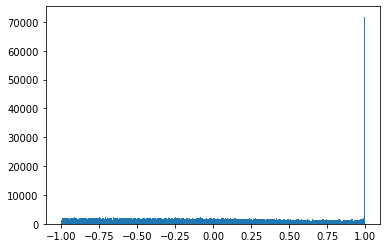

In [16]:
xn = 2.0 * xn.astype(np.float32) / 255.0 - 1.0
plt.hist(xn.reshape(-1),bins=256);

We also need to map the category _scalar_ to a category _vector_: 0 becomes (1,0,0,0), 1 becomes (0,1,0,0), 2 becomes (0,0,1,0) and 3 becomes (0,0,0,1). Keras has a utility for that `to_categorical`.

In [17]:
yn = tf.keras.utils.to_categorical(y)
yn[::20]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

Finaly we split the data in train, validate and test.

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_remainder, y_train, y_remainder = train_test_split(xn,yn,test_size=0.25)
x_valid, x_test, y_valid, y_test = train_test_split(x_remainder,y_remainder,test_size=0.5)

print( len(x_train), len(x_valid), len(x_test) )

300 50 50


# Setting up the neural network
Not having too much experience with neural network models, I decided to copy one.
I took the simplest "1-Conv CNN" from this [page](https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d). But, with a bit of experimenting, I reduced the numbers of neurons considerably.

The model is depitec below. It takes gray-scale images of 28×46 as input (red). 
It computes 6 feature layers (green) of 26×44 through a 2D convolution. 
Those are max-pooled (2×2) to 6 feature layers of 13×22 (blue).
The 6 times 13 times 22 values are flattened to 1716 floats (white). 
Those are densely mapped to 5 floats (purple), 
and those are densely mapped to the required 4 outputs (yellow): rock, paper, scissers, none.

![model](model.png)

In [19]:
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Conv2D(6, (3,3), activation='relu', input_shape=(28,46,1)) )
model.add( tf.keras.layers.MaxPooling2D(pool_size=(2,2)) )
model.add( tf.keras.layers.Flatten() )
model.add( tf.keras.layers.Dense(5, activation='relu') )
model.add( tf.keras.layers.Dense(4, activation='softmax') )

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 44, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 22, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1716)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8585      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 24        
Total params: 8,669
Trainable params: 8,669
Non-trainable params: 0
_________________________________________________________________


To my big surprise, in just a few epochs, this gives a high accuracy.

In [20]:
history = model.fit(x_train,y_train,epochs=15, batch_size=2, shuffle=True, validation_data=(x_valid,y_valid));

Epoch 1/15
150/150 [==============================] - 0s 2ms/step - loss: 0.8189 - accuracy: 0.6667 - val_loss: 0.4089 - val_accuracy: 0.8000
Epoch 2/15
150/150 [==============================] - 0s 926us/step - loss: 0.4204 - accuracy: 0.7667 - val_loss: 0.2278 - val_accuracy: 0.8400
Epoch 3/15
150/150 [==============================] - 0s 932us/step - loss: 0.2047 - accuracy: 0.9300 - val_loss: 0.0786 - val_accuracy: 1.0000
Epoch 4/15
150/150 [==============================] - 0s 920us/step - loss: 0.0476 - accuracy: 0.9967 - val_loss: 0.0460 - val_accuracy: 0.9800
Epoch 5/15
150/150 [==============================] - 0s 930us/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 6/15
150/150 [==============================] - 0s 940us/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 0.9800
Epoch 7/15
150/150 [==============================] - 0s 940us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0

The recorded history shows that the _loss_ very rapidly reaches 0.

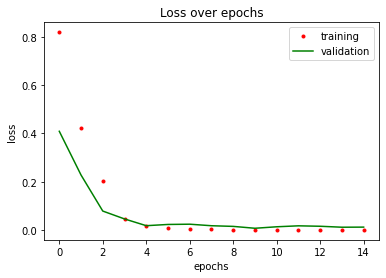

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_loss))
plt.plot( epochs, train_loss, 'r.', label="training" )
plt.plot( epochs, val_loss,   'g-', label="validation" )

plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

Similarly, the _accuracy_ rapidly reaches 1. A funny dip around epoch 12.

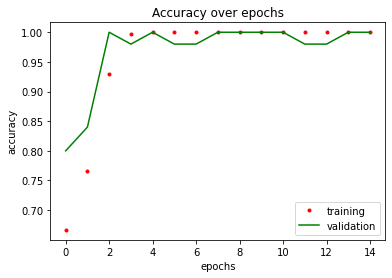

In [22]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(train_accuracy))
plt.plot( epochs, train_accuracy, 'r.', label="training" )
plt.plot( epochs, val_accuracy,   'g-', label="validation" )

plt.title('Accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

# Testing
Let's see how the model works on the test data.

In [23]:
result = model.evaluate(x_test, y_test)
test_size = len(x_test)
test_accuracy = result[1]
print( f"{test_size} test images: {round(test_size*test_accuracy)} ok, {round(test_size*(1-test_accuracy))} wrong" )

2/2 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000
50 test images: 50 ok, 0 wrong


No wrong predictions! 

Let see that in action for all our test images.
I made a helper function `summary` that takes an image and returns a summary of the prediction.

In [24]:
def summary(img,precision=2) :
    img = img.reshape( (1,)+img.shape) # predict() needs an array of images
    out = model.predict( img ) # we give at an array of 1 image
    def cat(cix) : return f"{out[0][cix]:1.{precision}f}{categories[cix][0:1]}" # returns a string for category `cix` of `out`
    lbl1 = f"{cat(0)} {cat(1)} {cat(2)} {cat(3)}" # Order is alphabetically: none, paper, rock, scissors
    lbl2 = f"pred: {categories[np.argmax(out)]}"
    return lbl1+"\n"+lbl2
summary(x_test[0],4)

'0.0000n 0.9993p 0.0000r 0.0007s\npred: paper'

We see here that test item 0 (`x_test[0]`) is predicted to be "paper" (bottom line). The first line shows the four outputs from the prediction of the model: 0.0000 for none, 0.9993 for papper, 0.0000 for rock, an 0.0007 for scissors. So, indeed a big win papers.

We now print a grid for all test data.

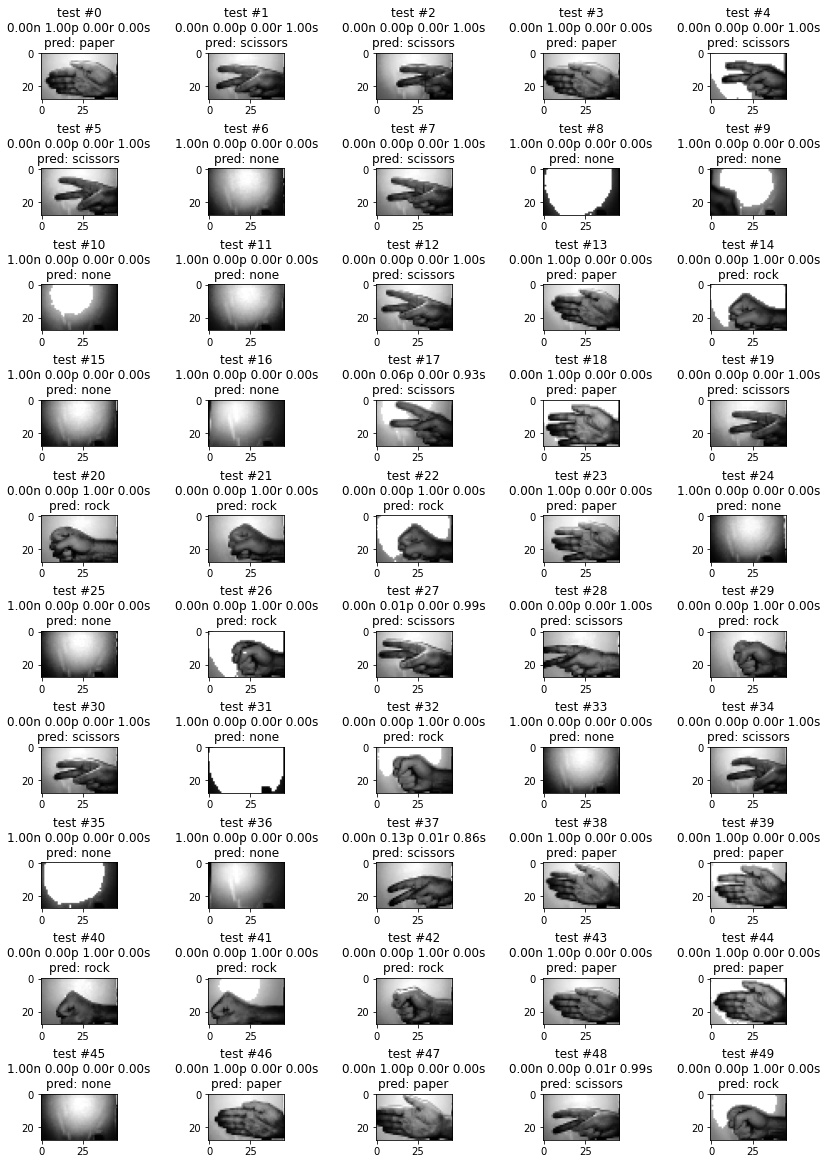

In [25]:
rows = 10
cols = 5
fig = plt.figure(n*n,figsize=(15,20))
fig.subplots_adjust(wspace=0.0,hspace=1.5)
for yy in range(rows):
    for xx in range(cols):
        ix = yy*cols+xx
        ax = fig.add_subplot(rows,cols,ix+1)
        ax.title.set_text( f"test #{ix}\n{summary(x_test[ix])}" )
        plt.imshow(x_test[ix],cmap='gray')

We save this model.

In [26]:
model.save('rps.h5')

# TensorFlow Lite

We have a model with 100% accuracy on the test set. It has less than 10k parameters (8,669), so even when stored as floats that is about 40k bytes. Should fit on an ESP32. So TensorFlow Lite seems within reach.

We convert the model and save as flatbuffer (`opemp` for "optimizations set is empty").

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []
model_lite_opemp = converter.convert()
open("rps.opemp.tflite", "wb").write(model_lite_opemp)

INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpfqfd79xc\assets


37088

Since reducing 10k floats to uint8 gives us a factor of 4 in savings we might as well give that a try. The default optimizations seem to do that.

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
model_lite_opdef = converter.convert()
open("rps.opdef.tflite", "wb").write(model_lite_opdef)

INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpdnrt737v\assets


INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpdnrt737v\assets


11552

An overview of all saved model variants.

In [29]:
!dir  rps.*

 Volume in drive C has no label.
 Volume Serial Number is B2F0-CF6D

 Directory of C:\Repos\MachineLearning\rock-paper-scissors

2021 08 21  22:52           137,200 rps.h5
2021 08 21  22:52            11,552 rps.opdef.tflite
2021 08 21  22:52            37,088 rps.opemp.tflite
               3 File(s)        185,840 bytes
               0 Dir(s)  263,002,689,536 bytes free


The `opdef` variant is more than 10 times as small as the standard tensorflow variant.
So the `opdef` sounds good, and at first I used that one, in the chapter below, to map it to the ESP32. 
Hoever, the ESP32 produced an error when initializing the TFL library.

> The ESP32 gave this error: `Didn't find op for builtin opcode 'CONV_2D' version '5'. Failed to get registration from op code  d`. I interpret this as follows. When applying optimizations, special instructions are generated for the interpreter ("op code d"). The TensorFlow Lite for ESP32 microcontroller is lagging behind and it doesn't have this instruction yet. Without optimizations, no special instructions are needed, and my ESP32 interpreter can handle the model. So I decided to stick to the `opemp`. 

We instantiate a lite interpreter, allocate memory for its tensors, and get the input and output "details".

In [30]:
interpreter = tf.lite.Interpreter("rps.opemp.tflite")
interpreter.allocate_tensors()
dinput = interpreter.get_input_details()
doutput = interpreter.get_output_details()

Those "details" are hard to understand. Here are the ones for the input.

In [31]:
dinput

[{'name': 'conv2d_input',
  'index': 0,
  'shape': array([ 1, 28, 46,  1]),
  'shape_signature': array([-1, 28, 46,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

`dinput` is a list, but a singleton.
It tells that the input shall be stored at "index" 0, whatever that means.
The `shape` is an array of 28×46×1, and the array elements are `float32`.
This (nearly) matches our data:

In [32]:
x_test[0].shape, x_test[0].dtype

((28, 46, 1), dtype('float32'))

Nearly, because we need (1,28,46,1), not (28,46,1), but we know how to fix that: `x.reshape( (1,)+x.shape )`!

In [33]:
doutput

[{'name': 'Identity',
  'index': 13,
  'shape': array([1, 4]),
  'shape_signature': array([-1,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

We find the output can be obtained at "index" 13. The output `shape` also has a spurious extra dimension, which is easy to fix: index it `[0]`!

This leads to the following code to check our test set.

In [34]:
count_ok = 0
count_err = 0
print( f"{'TEST':4}  {'PREDICT':45} {'ACTUAL':29} {'MESSAGE'}")
for i,x in enumerate(x_test):
    # Prep input, predict, get output
    xx = x.reshape( (1,)+x.shape) # fix input shape
    interpreter.set_tensor( dinput[0]['index'], xx ) # access the one element, and get the 'index'
    interpreter.invoke()
    yy = interpreter.get_tensor( doutput[0]['index'] ) # access the one element, and get the 'index'
    y = yy[0] # fix output shape
    # Get the predicted and actual category
    cat_pred = np.argmax(y)
    cat_act = np.argmax(y_test[i])
    if cat_pred == cat_act :
        msg="ok"
        count_ok+=1
    else :
        msg="ERROR"
        count_err+=1
    # Print table
    predict = f"[{y[0]:.4f} {y[1]:.4f} {y[2]:.4f} {y[3]:.4f}] = {cat_pred} = {categories[cat_pred]:8}"
    actual  = f"{y_test[i]} = {cat_act} = {categories[cat_act]:8}"
    print( f"{i:04d}  {predict}  {actual}  {msg}")
print( f"Correct {count_ok}, errors {count_err}" )

TEST  PREDICT                                       ACTUAL                        MESSAGE
0000  [0.0000 0.9993 0.0000 0.0007] = 1 = paper     [0. 1. 0. 0.] = 1 = paper     ok
0001  [0.0004 0.0004 0.0000 0.9992] = 3 = scissors  [0. 0. 0. 1.] = 3 = scissors  ok
0002  [0.0002 0.0001 0.0000 0.9998] = 3 = scissors  [0. 0. 0. 1.] = 3 = scissors  ok
0003  [0.0000 0.9992 0.0000 0.0008] = 1 = paper     [0. 1. 0. 0.] = 1 = paper     ok
0004  [0.0000 0.0009 0.0000 0.9991] = 3 = scissors  [0. 0. 0. 1.] = 3 = scissors  ok
0005  [0.0002 0.0000 0.0000 0.9998] = 3 = scissors  [0. 0. 0. 1.] = 3 = scissors  ok
0006  [1.0000 0.0000 0.0000 0.0000] = 0 = none      [1. 0. 0. 0.] = 0 = none      ok
0007  [0.0001 0.0000 0.0000 0.9998] = 3 = scissors  [0. 0. 0. 1.] = 3 = scissors  ok
0008  [1.0000 0.0000 0.0000 0.0000] = 0 = none      [1. 0. 0. 0.] = 0 = none      ok
0009  [1.0000 0.0000 0.0000 0.0000] = 0 = none      [1. 0. 0. 0.] = 0 = none      ok
0010  [0.9999 0.0000 0.0001 0.0000] = 0 = none      [1. 0. 0

We get the same result for the test set in TensorFlow Lite as for tensorFlow standard: 100% accuracy.

# Port to ESP32

Next step is to try the model on the ESP32 itself. For that, we need to save the FlatBuffer as a C-array. I recycled the `bytes2carray()` from the [sine project](../sine/sine.ipynb).

In [35]:
import datetime 
def bytes2carray(b1,dir=".",name="model") :
    # b1 = b'\x1c\x00\x00...'
    b2 = [ f"0x{byte:02X}" for byte in b1 ]
    # b2 = ['0x1C', '0x00', '0x00', ...]
    b3 = ', '.join( b2 )
    # b3 = '0x1C, 0x00, 0x00, ...'
    n = len("0x##, ")*8
    b4 = [ b3[i:i+n] for i in range(0,len(b3),n)]
    # b4 = [ '0x1C, 0x00, 0x00, <5more>', '0x14, 0x00, 0x20, <5more>', ...]
    b5 = '\n  '.join(b4)
    # b5 = [ '0x1C, 0x00, 0x00, <5more>\n    ', '0x14, 0x00, 0x20, <5more>\n    ', ...]
    pre0 = f"// {name}.h - TensorFlow lite model - {datetime.datetime.now()}"
    pre1 = f"#define {name.upper()}_LEN {len(b1)}"
    pre2 = f"#define {name.upper()}_ALIGN __attribute__((aligned(4)))"
    pre3 = f"const unsigned char {name}_data[{name.upper()}_LEN] {name.upper()}_ALIGN = {{"
    post1= f"}};" # {} characters need escaping in f-strings
    b6 = f"{pre0}\n\n{pre1}\n\n{pre2}\n\n{pre3}\n  {b5}\n{post1}\n"
    return open( f"{dir}/{name}.h", "w").write(b6)

We use this function to create a file `model.h` in subdirectory `rps32` (directory for the Arduino sketch of the ESP32 test application).

In [36]:
bytes2carray(model_lite_opemp,dir="rps32",name="rps32model");

The first and last 10 lines look like this

In [37]:
lines = open("rps32/rps32model.h","r").readlines()
print( f"{''.join(lines[:10])}  ...\n{''.join(lines[-10:])}" )

// rps32model.h - TensorFlow lite model - 2021-08-21 22:52:52.794332

#define RPS32MODEL_LEN 37088

#define RPS32MODEL_ALIGN __attribute__((aligned(4)))

const unsigned char rps32model_data[RPS32MODEL_LEN] RPS32MODEL_ALIGN = {
  0x1C, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4C, 0x33, 
  0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 
  0x0C, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 
  ...
  0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x1C, 0x00, 0x00, 0x00, 0x2E, 0x00, 0x00, 0x00, 
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 
  0xFF, 0xFF, 0xFF, 0xFF, 0x1C, 0x00, 0x00, 0x00, 
  0x2E, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
  0x0C, 0x00, 0x00, 0x00, 0x63, 0x6F, 0x6E, 0x76, 
  0x32, 0x64, 0x5F, 0x69, 0x6E, 0x70, 0x75, 0x74, 
  0x00, 0x00, 0x00, 0x00, 0xFC, 0xFF, 0xFF, 0xFF, 
  0x04, 0x00, 0x04, 0x00, 0x04, 0x00, 0x00, 0x00
};



Recall that the size of the FlatBuffer file `rps.opemp.tflite` was 37,088. That is the same as the size of the array `model_data`.

To check the results on ESP32, we export the test data to C. We have the following helper function.

In [38]:
def floatimg2carray(imgs,dir=".",name="test") :
    simgs = f"// {name}.h - image data - {datetime.datetime.now()}\n\n"
    simgs+= f"#define {name.upper()}_COUNT  {len(imgs)}\n"
    simgs+= f"#define {name.upper()}_HEIGHT {len(imgs[0])}\n"
    simgs+= f"#define {name.upper()}_WIDTH  {len(imgs[0][0])}\n\n"
    simgs+= f"const float {name}_data[{name.upper()}_COUNT][{name.upper()}_HEIGHT][{name.upper()}_WIDTH] = {{\n"
    for iix,img in enumerate(imgs) :
        simg = f"  {{ // img {iix}\n"
        for rix,row in enumerate(img) :
            srow = "    { "
            for val in row.flatten() :
                srow += f"{val}, "
            srow += f"}}, // row {rix}\n"
            simg += srow
        simg += f"  }}, // img {iix}\n"
        simgs += simg
    simgs += f"}};\n"

    return open( f"{dir}/{name}.h", "w").write(simgs)

We use this function to create a file in subdirectory `rps32` (directory for the Arduino sketch of the ESP32 test application) with all test data in a c-array.

In [39]:
floatimg2carray(x_test,dir="rps32",name="rps32test")

1235919

The first and last lines look like this.

In [40]:
lines = open("rps32/rps32test.h","r").readlines()
print( f"{''.join(lines[:11])}    ...\n{''.join(lines[-3:])}" )

// rps32test.h - image data - 2021-08-21 22:52:52.833341

#define RPS32TEST_COUNT  50
#define RPS32TEST_HEIGHT 28
#define RPS32TEST_WIDTH  46

const float rps32test_data[RPS32TEST_COUNT][RPS32TEST_HEIGHT][RPS32TEST_WIDTH] = {
  { // img 0
    { 0.3176470994949341, 0.3490196466445923, 0.40392160415649414, 0.41960787773132324, 0.5137255191802979, 0.529411792755127, 0.5686274766921997, 0.615686297416687, 0.6627451181411743, 0.686274528503418, 0.7176470756530762, 0.7411764860153198, 0.7647058963775635, 0.7960784435272217, 0.8039215803146362, 0.8196078538894653, 0.8588235378265381, 0.8823529481887817, 0.8901960849761963, 0.9215686321258545, 0.9215686321258545, 0.9215686321258545, 0.9372549057006836, 0.9372549057006836, 0.9529411792755127, 0.9529411792755127, 0.9372549057006836, 0.9215686321258545, 0.9215686321258545, 0.8901960849761963, 0.8823529481887817, 0.8509804010391235, 0.8352941274642944, 0.7960784435272217, 0.7803921699523926, 0.7490196228027344, 0.7176470756530762, 0.68627452850341

With the model in `model.h` and the test data in `test.h`, we need a simple app to run `predict()` on each of the test images.
This ino file is in the same directory [rps32](rps) as the other two files.

```c
// rps32.ino - sketch used to check the test data with the TensorFlow Lite model
#include <EloquentTinyML.h> // From https://github.com/eloquentarduino/EloquentTinyML
#include "rps32model.h"     // From https://github.com/maarten-pennings/MachineLearning/tree/main/rock-paper-scissors
#include "rps32test.h"      // From https://github.com/maarten-pennings/MachineLearning/tree/main/rock-paper-scissors

#define NUMBER_OF_INPUTS    ( RPS32TEST_HEIGHT * RPS32TEST_WIDTH )
#define NUMBER_OF_OUTPUTS   4
#define TENSOR_ARENA_SIZE   ( 50*1024 ) 

Eloquent::TinyML::TfLite<
    NUMBER_OF_INPUTS, 
    NUMBER_OF_OUTPUTS, 
    TENSOR_ARENA_SIZE
> tflu;

void setup() {
  Serial.begin(115200);
  while( !Serial ) delay(100);
  Serial.printf("\nrps32\n");
  tflu.begin(rps32model_data);
}

int count = 0;

void loop() {
  if( count>=RPS32TEST_COUNT ) return;
  
  Serial.printf("image %04d ", count); 

  float output[NUMBER_OF_OUTPUTS];
  uint32_t time0 = micros();
  tflu.predict((float*)&rps32test_data[count],output);
  uint32_t time1 = micros();
  Serial.printf("n=%.4f p=%.4f r=%.4f s=%.4f time=%uus\n",output[0],output[1],output[2],output[3], time1-time0);

  count++;
}
```

One of the configuration parameters for the interpreter is the `TENSOR_ARENA_SIZE`. The `EloquentTinyML` suggest trial and error, but there is some rationale behind it.

![memory](memory.png)

The top part of the figure above shows an abstract model. I try to avoid the words "layer" and "neuron" because they are not precise for me in this context. What the drawing shows is green "pixels" and blue "computations". We have input pixels, output pixels and hidden pixels (layers?). But the crux is that the "pixels" contain dynamic data; this is what is shot with the camera and what is infered by the interpreter until we have output: **the green data must be in RAM**. The "blue" parts depict the computation: weighted sum, adding bias, activation. This eats the compute cycles. It also requires configuration data (the "weights"). They are coming from the FlatBuffer, they don't change, they are part of the application code: **the blue parameters are in flash**. 

If a _model_ is too big (e.g. simply too many layers, or too many weights because some layers have too many pixels) the build fails on flash size. If there are too many pixels the build fails on RAM size.

How much flash do we need for a model? That is an easy question. The weights (and biases, configuration, interpreter instructions) are all part of the application; they are in the FlatBuffer, that is in `model_data[]` defined in `model.h`. And we know how big that is, it is also in `model.h`: `#define MODEL_LEN 37088`. Which is the same as the file size of the tflite file `rps.opemp.tflite`.

How much RAM do we need (during inference)? That is a bit harder. As the bottom part of the above figure suggest, the computation is executed in steps. The first step transfers pixels 1 to pixels 2, the second step transfers pixels 2 to pixels 3, and so on. So during compute step _n_ we only need pixels _n_ as source and store pixels _n+1_ to destination. For the next step _n+1_, we use the just computed pixels _n+1_ as source. The RAM that was for _n_ is now used to store the destination pixels _n+2_. So the RAM we need is the maximum used during any step: _(size1+size2) max (size2+size3) max (size3+size4) max (size4+size5)_.

We go back to our model to do the RAM analysis.

| description   | pixels 1 | step 1 | pixels 2 | step 2 | pixels 3 | step 3 | pixels 4 | step 4 |pixels 5 | step 5 | pixels 6 |
|:-------------:|:--------:|:------:|:--------:|:------:|:--------:|:------:|:--------:|:------:|:-------:|:------:|:--------:|
| resolution    |  28×46×1 |        |  26×44×6 |        |  13×22×6 |        |    1716  |        |     5   |        |     4    |
| count         |    1288  |        |    6864  |        |    1716  |        |    1716  |        |     5   |        |     4    |
| step          |          |  8152  |          |  8580  |          |  3432  |          |   1721 |         |    9   |          |
| size float=4  |          | 32608  |          | 34320  |          | 13728  |          |   6884 |         |   36   |          |

Conclusion, the biggest RAM usage is during step 2: the model needs to transform 6864 floats to 1716 floats. Storage need is this 8580 floats or 34320 bytes.

On purpose, I did set `TENSOR_ARENA_SIZE` too small:

```
#define TENSOR_ARENA_SIZE   (32*1024) // Trial and error
```

When we then run the application we get an error

```
Arena size is too small for activation buffers. Needed 34320 but only 31236 was available.
```

We see the TensorFlow Lite library complain that it needs 34320, the exact number we predicted.
I do not fully understand why it says that only 31236 is available, we configured 32×1024 and that is a bit bigger: 32768. 
Somehow 1532 (32*1024 - 31236) bytes are needed somewhere else.

With `TENSOR_ARENA_SIZE` a bit bigger, we can run the app.

When we compile the app (of course after installing the [EloquentTinyML.h](https://github.com/eloquentarduino/EloquentTinyML) library in Arduino) we get this info.

```text
Sketch uses 758226 bytes (24%) of program storage space. Maximum is 3145728 bytes.
Global variables use 70988 bytes (21%) of dynamic memory, leaving 256692 bytes for local variables. Maximum is 327680 bytes.
```

So still plenty of room.

How are the prediction results?

```text
rps32
image 0000 n=0.0000 p=0.9993 r=0.0000 s=0.0007 time=65667us
image 0001 n=0.0004 p=0.0004 r=0.0000 s=0.9992 time=65299us
image 0002 n=0.0002 p=0.0001 r=0.0000 s=0.9998 time=65234us
image 0003 n=0.0000 p=0.9992 r=0.0000 s=0.0008 time=65193us
image 0004 n=0.0000 p=0.0009 r=0.0000 s=0.9991 time=65251us
image 0005 n=0.0002 p=0.0000 r=0.0000 s=0.9998 time=65376us
image 0006 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65165us
image 0007 n=0.0001 p=0.0000 r=0.0000 s=0.9998 time=65235us
image 0008 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65434us
image 0009 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65164us
image 0010 n=0.9999 p=0.0000 r=0.0001 s=0.0000 time=65220us
image 0011 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65398us
image 0012 n=0.0004 p=0.0016 r=0.0002 s=0.9977 time=65202us
image 0013 n=0.0000 p=0.9999 r=0.0000 s=0.0001 time=65218us
image 0014 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65311us
image 0015 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65270us
image 0016 n=0.9999 p=0.0000 r=0.0000 s=0.0001 time=65252us
image 0017 n=0.0003 p=0.0607 r=0.0042 s=0.9348 time=65260us
image 0018 n=0.0000 p=1.0000 r=0.0000 s=0.0000 time=65226us
image 0019 n=0.0003 p=0.0001 r=0.0000 s=0.9996 time=65233us
image 0020 n=0.0000 p=0.0004 r=0.9995 s=0.0001 time=65271us
image 0021 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65358us
image 0022 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65200us
image 0023 n=0.0000 p=0.9999 r=0.0000 s=0.0000 time=65216us
image 0024 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65426us
image 0025 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65183us
image 0026 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65220us
image 0027 n=0.0002 p=0.0103 r=0.0003 s=0.9892 time=65432us
image 0028 n=0.0001 p=0.0024 r=0.0000 s=0.9975 time=65074us
image 0029 n=0.0000 p=0.0000 r=0.9995 s=0.0004 time=65206us
image 0030 n=0.0002 p=0.0001 r=0.0000 s=0.9997 time=65376us
image 0031 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65207us
image 0032 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65250us
image 0033 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65257us
image 0034 n=0.0003 p=0.0001 r=0.0000 s=0.9997 time=65308us
image 0035 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65218us
image 0036 n=0.9999 p=0.0000 r=0.0000 s=0.0001 time=65273us
image 0037 n=0.0002 p=0.1348 r=0.0078 s=0.8572 time=65310us
image 0038 n=0.0000 p=0.9999 r=0.0000 s=0.0001 time=65116us
image 0039 n=0.0000 p=1.0000 r=0.0000 s=0.0000 time=65240us
image 0040 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65399us
image 0041 n=0.0002 p=0.0001 r=0.9995 s=0.0002 time=65180us
image 0042 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65226us
image 0043 n=0.0000 p=0.9986 r=0.0000 s=0.0014 time=65433us
image 0044 n=0.0000 p=1.0000 r=0.0000 s=0.0000 time=65150us
image 0045 n=1.0000 p=0.0000 r=0.0000 s=0.0000 time=65218us
image 0046 n=0.0000 p=1.0000 r=0.0000 s=0.0000 time=65404us
image 0047 n=0.0000 p=0.9999 r=0.0000 s=0.0001 time=65188us
image 0048 n=0.0009 p=0.0048 r=0.0078 s=0.9865 time=65218us
image 0049 n=0.0000 p=0.0000 r=1.0000 s=0.0000 time=65236us
```

Looks like a perfect match with the Python run.

Frame rate is slightly above 65ms or 15FPS.

# Running the model

When running the model on live footage instead of the test data, the results turned out to be dramatically bad.
At first I was not sure what is going on. Is my training set too small and the model overfitted to that?

For example, I tried 10 shots without any hand:

```
cat=rock     n=0.1142 p=0.0000 r=0.8858 s=0.0000 time=65310us
cat=rock     n=0.0824 p=0.0000 r=0.9176 s=0.0000 time=64888us
cat=rock     n=0.1922 p=0.0000 r=0.8078 s=0.0000 time=64886us
cat=none     n=0.9981 p=0.0007 r=0.0000 s=0.0012 time=64883us
cat=rock     n=0.1142 p=0.0000 r=0.8858 s=0.0000 time=64890us
cat=rock     n=0.0591 p=0.0000 r=0.9409 s=0.0000 time=64882us
cat=none     n=0.9962 p=0.0000 r=0.0037 s=0.0000 time=64887us
cat=rock     n=0.0637 p=0.0000 r=0.9363 s=0.0000 time=64876us
cat=rock     n=0.0266 p=0.0000 r=0.9734 s=0.0000 time=64885us
cat=rock     n=0.1639 p=0.0000 r=0.8361 s=0.0000 time=64887us
```

That is 20% correct predictions (`none`) and 80% incorrect (`rock`)!

We had 100%-0% :-(

Since the PC training material had 100% accuracy on th ESP32, I debugged by going the other way.
I took a single shot on ESP32, one that failed, and ported that back that back to the PC, 
and ran it in Python (they were actually chapters in this notebook).

I solved the issue: the x and y coordinates of the camera framebuffer were rotated and mirrored with respect
to the ones the TensorFlow Lite interpreter expects them.

The Arduino app is running fine now. It is stored in the 
[ESP32-CAM](https://github.com/maarten-pennings/esp32cam/tree/main/rock-paper-scissors/esp32cam-predict) repo.

I made a short [video](https://www.youtube.com/watch?v=dVIRe2fjQL4).

(end)